@ CEREAL DATA
This looks at world bank data for cereal production (metric tons) and hectares in production

In [1]:
# import libraries

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import xarray as xr
from scipy import stats
import pooch
import os
import tempfile
import pandas as pd
import s3fs
import boto3
import botocore
import datetime

In [2]:
# helper functions

def pooch_load(filelocation=None,filename=None,processor=None):
    shared_location='/home/jovyan/shared/Data/Projects/Precipitation' # this is different for each day
    user_temp_cache=tempfile.gettempdir()
    
    if os.path.exists(os.path.join(shared_location,filename)):
        file = os.path.join(shared_location,filename)
    else:
        file = pooch.retrieve(filelocation,known_hash=None,fname=os.path.join(user_temp_cache,filename),processor=processor)

    return file

In [3]:
# code to retrieve and load the data

filename_cereal = 'data_cereal_land.csv'
url_cereal = 'https://raw.githubusercontent.com/Sshamekh/Heatwave/f85f43997e3d6ae61e5d729bf77cfcc188fbf2fd/data_cereal_land.csv'
ds_cereal_land = pd.read_csv(pooch_load(url_cereal,filename_cereal))

#ds_cereal_land[0:2]

In [4]:
# copy (name change for convenience) and checks
ds = ds_cereal_land.copy()

# check dataset
# ds.shape
# ds.head()  # ds[50:70]

# Print dates 
# print(ds.columns.tolist())


In [5]:
# select relevant countries
# from: Southeast Cameroon (33%); western Tanzania (20%); northeast Zambia (15%); northeast Angola(15%); DRC; Congo Republic (75%) not southwest; 
# southern Central African Republic (50%); N.B. no WB data for Equatorial Guinea
# Angola, Cameroon, Central African Republic, Democratic Republic of the Congo, Republic of the Congo, Zambia [ https://cridf.net/cribmap/ ]
# country data
countries = ["Angola", "Cameroon", "Central African Republic", "Congo, Dem. Rep.", "Congo, Rep.", "Zambia"]
# countries = ["Cameroon", "Central African Republic", "Congo, Dem. Rep.","Congo, Rep.", "Gabon"] 

# names for plotting
country_names = ["Angola", "Cameroon", "CAF", "DRC", "Rep. Congo", "Zambia"]
# country_names = ["Cameroon", "CAF", "DRC", "Rep. Congo", "Gabon"] # no data for Equatorial Guinea
           
ds = ds.loc[ds["Country Name"].isin(countries)]

# df.loc[df['column_name'].isin(some_values)]

In [6]:
# select years 1972:1981
ds_1972_1981 = ds.loc[:,['Country Name', 'Series Name', '1972 [YR1972]', '1973 [YR1973]', '1974 [YR1974]', '1975 [YR1975]', '1976 [YR1976]', '1977 [YR1977]', '1978 [YR1978]', '1979 [YR1979]', '1980 [YR1980]', '1981 [YR1981]']]

# select years 2012:2021
ds_2012_2021 = ds.loc[:,['Country Name', 'Series Name', '2012 [YR2012]', '2013 [YR2013]', '2014 [YR2014]', '2015 [YR2015]', '2016 [YR2016]', '2017 [YR2017]', '2018 [YR2018]', '2019 [YR2019]', '2020 [YR2020]', '2021 [YR2021]']]

ds_1972_1981

Country Name                              Series Name  \
10                     Angola          Cereal production (metric tons)   
11                     Angola  Land under cereal production (hectares)   
68                   Cameroon          Cereal production (metric tons)   
69                   Cameroon  Land under cereal production (hectares)   
74   Central African Republic          Cereal production (metric tons)   
75   Central African Republic  Land under cereal production (hectares)   
88           Congo, Dem. Rep.          Cereal production (metric tons)   
89           Congo, Dem. Rep.  Land under cereal production (hectares)   
90                Congo, Rep.          Cereal production (metric tons)   
91                Congo, Rep.  Land under cereal production (hectares)   
430                    Zambia          Cereal production (metric tons)   
431                    Zambia  Land under cereal production (hectares)   

    1972 [YR1972] 1973 [YR1973] 1974 [YR1974] 1975 [YR1975] 1976 [YR1976]  \
10         513417        548578        513764        558000        563000   
11         658000        718000        721000        721000        726000   
68         777845        769867        860079       1102526        834899   
69         948409        998927        975229       1042516        964175   
74          99900        103650        101362         94672         96000   
75         143500        151810        201692        177461        182500   
88         701555        712224        735654        759021        773400   
89         939813        961069        988829       1015151       1037000   
90          11701         12229         18431         20650         20860   
91          13084         18000         26099         31883         32180   
430       1380494       1027462       1236246       1616425       1744399   
431       1370810       1225000       1277501       1232834       1268036   

    1977 [YR1977] 1978 [YR1978] 1979 [YR1979] 1980 [YR1980] 1981 [YR1981]  
10         430000        475000        361000        435000        316000  
11         713000        712000        709000        704000        700500  
68         846930        887449        872186        891774        834621  
69         981715       1060681       1066582       1031730        964842  
74          93000         92918         93145         99862        116073  
75         178000        156056        187340        191665        203789  
88         779900        770800        868800        889000        940900  
89        1055000       1057500       1087400       1113100       1144000  
90          21011         13500         20000         11713         13400  
91          31900         29500         29000         13855         13700  
430       1736114       1470553        936139        984244       1050738  
431       1153785        970400        612200        627910        544245

In [7]:
# get metric tons (MT): percentage increase

ds_1972_1981_MT = ds_1972_1981.iloc[0:-1:2,:] # get even numbered entries (MT)
ds_2012_2021_MT = ds_2012_2021.iloc[0:-1:2,:] 
              
# convert text to float
ds_1972_1981_MT = ds_1972_1981_MT.iloc[:, 2:].astype('float').round(decimals=0)   #ds.astype ('float') ;  # pd.to_numeric
ds_2012_2021_MT = ds_2012_2021_MT.iloc[:, 2:].astype('float').round(decimals=0)

# calculate country means for late and early period
country_mean_MT_2012_2021 = np.nanmean([ds_2012_2021_MT], axis = 2)
country_mean_MT_1972_1981 = np.nanmean([ds_1972_1981_MT], axis = 2 )

# increase in cereal production (MT)
increase_MT = country_mean_MT_2012_2021 - country_mean_MT_1972_1981

# increase in percentage
increase_percent_MT = 100 * (country_mean_MT_2012_2021 / country_mean_MT_1972_1981)

#print
increase_percent_MT


array([[483.97817962, 413.55224877, 161.26590227, 418.10337936,
        178.30331203, 243.82145572]])

In [8]:
# get hectares under production (HA)

ds_1972_1981_HA = ds_1972_1981.iloc[1:-1:2,:] # get odd numbered entries (HA)
ds_2012_2021_HA = ds_2012_2021.iloc[1:-1:2,:] 
              
# text to float
ds_1972_1981_HA = ds_1972_1981_MT.iloc[:, 2:].astype('float').round(decimals=0)   #ds.astype ('float') ;  # pd.to_numeric
ds_2012_2021_HA = ds_2012_2021_MT.iloc[:, 2:].astype('float').round(decimals=0)

# calculate country means for late and early period
country_mean_HA_2012_2021 = np.nanmean([ds_2012_2021_HA], axis = 2)
country_mean_HA_1972_1981 = np.nanmean([ds_1972_1981_HA], axis = 2)

# print
# country_mean_HA_2012_2021.round(decimals=0), country_mean_HA_1972_1981.round(decimals=0) 

# increase in cropland
increase_HA = country_mean_HA_2012_2021 - country_mean_HA_1972_1981

# increase in percentage
increase_percent_HA = 100 * (country_mean_HA_2012_2021 / country_mean_HA_1972_1981)

# print
# country_mean_HA_2012_2021
# increase_percent_HA
country_mean_HA_1972_1981

array([[ 456470.5  ,  891308.   ,   98379.   ,  814684.375,   17445.625,
        1346857.25 ]])

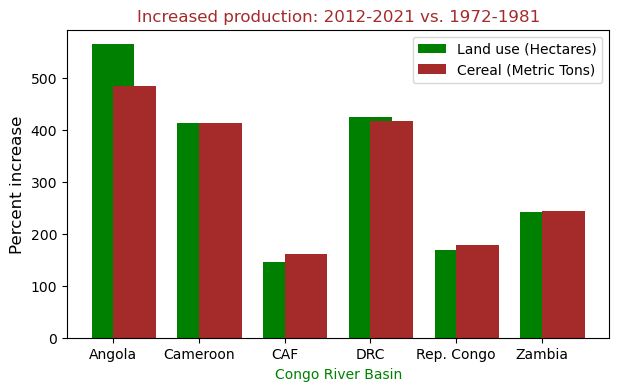

In [9]:
# PLOT INCREASES

# define the plot size
fig = plt.figure(figsize=(7, 4))
ax = plt.subplot(1,1,1)

ax.bar(country_names, increase_percent_HA[0,:], color = 'g', label = "Land use (Hectares)", width = 0.5, align='center')    #, facecolor="brown")
ax.bar(country_names, increase_percent_MT[0,:], color = "brown", label = "Cereal (Metric Tons)", width = 0.5, align='edge')    #, facecolor="brown")
ax.legend()
ax.set_xlabel('Congo River Basin', color='g')
ax.set_ylabel('Percent increase', fontsize = 12)
ax.set_title('Increased production: 2012-2021 vs. 1972-1981', color = "brown")

plt.savefig("Cereal_percentChange.png")

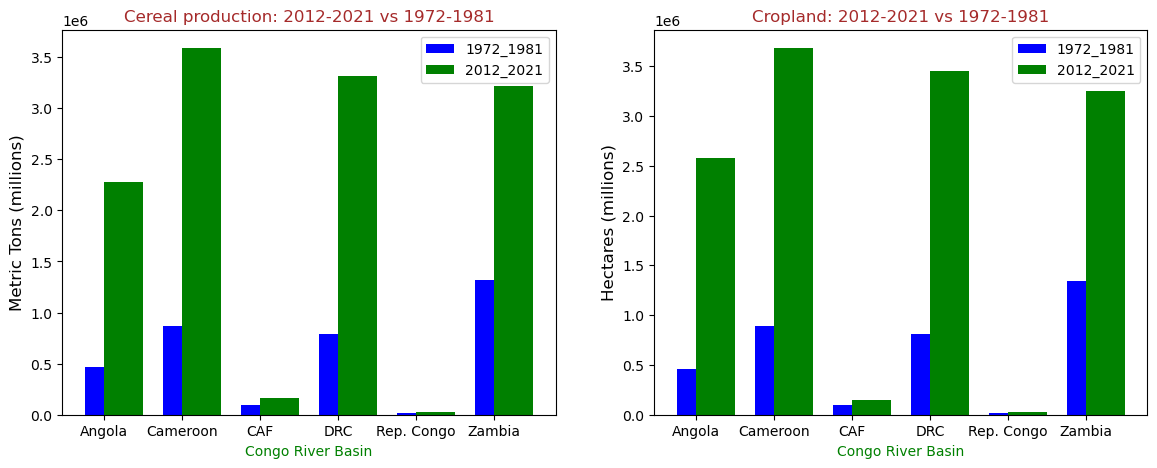

In [10]:
# PLOT
# MT = increase_MT[0,:]
# HA = increase_HA[0,:]

# define the plot size
fig = plt.figure(figsize=(14, 5))

# subplot for cereal production
ax = fig.add_subplot(1, 2, 1)
ax.bar(country_names, country_mean_MT_1972_1981[0,:], color = 'b', label = "1972_1981", width = 0.5, align='center')    #, facecolor="brown")
ax.bar(country_names, country_mean_MT_2012_2021[0,:], color = 'g', label = "2012_2021", width = 0.5, align='edge')    #, facecolor="brown")
ax.legend(loc='best')
ax.set_xlabel('Congo River Basin', color='g')
ax.set_ylabel('Metric Tons (millions)', fontsize = 12)
ax.set_title('Cereal production: 2012-2021 vs 1972-1981', color = "brown")


# subplot for cereal production
ax = fig.add_subplot(1, 2, 2)
ax.bar(country_names, country_mean_HA_1972_1981[0,:], color="b", label= "1972_1981", width=0.5, align='center')    #, facecolor="brown")
ax.bar(country_names, country_mean_HA_2012_2021[0,:], color="g", label= "2012_2021", width=0.5, align='edge')    #, facecolor="brown")

# ax.legend(loc='upper left')
ax.legend(loc='best')
ax.set_ylabel('Hectares (millions)', fontsize=12)
ax.set_xlabel('Congo River Basin', color='g')
ax.set_title('Cropland: 2012-2021 vs 1972-1981', color = "brown")

plt.savefig("Cereal_Cropland.png")